In [1]:
import os
import random
from hashlib import sha256
from itertools import accumulate

import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

# fix gpu memory management 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# enable reproducibility
SEED = 42
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Text(0.5, 1.0, 'ship')

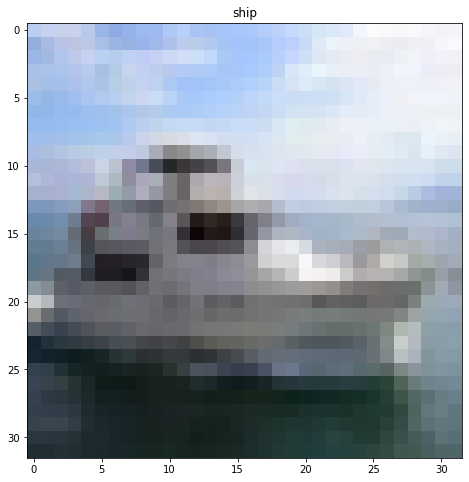

In [3]:
idx = np.random.choice(len(x_train))
plt.imshow(x_train[idx])
plt.title(labels[y_train[idx, 0]])

In [41]:
class Signature:
    """
    An array of randomly generated weights and their respective indices in the flattened weights array of a model.
    Signature length can either be set using
    """
    def __init__(self, data, model, ratio=None, length=None, hash_fn=sha256):
        self.rand_gen = self.gen_state(data, hash_fn)
        
        self.model_size = model.count_params()
        if length is None and ratio is None:
            raise ValueError("Length of the signature should be specified (use ratio or length)")
        if ratio is not None:
            self.length = int(ratio*self.model_size)
        elif length is not None:
            self.length = length

        self.weights = self.gen_weights()
        self.idx = self.gen_indices()
        assert len(self.weights) == len(self.idx) == self.length
        print(f'Created signature with {self.length} parameters')
    
    def gen_state(self, data, hash_fn):
        """
        Generates a random state that can be used as reproducible number generator from a bytes object
        """
        h = hash_fn(data).hexdigest()
        seed = int(h, 16) % pow(2, 32) # random state needs an integer between 0 and 2^32-1 
        return np.random.RandomState(seed)
    
    def gen_weights(self, distribution="uniform"):
        """
        Generate n random weights from a uniform distribution seeded with seed
        """
        if distribution == "uniform":
            return self.rand_gen.uniform(-1, 1, self.length).astype('float32')
        else:
            raise NotImplementedError()
    
    def gen_indices(self, distribution="uniform"):
        """
        Generate n indices in the interval [0, self.model_size-1] from a uniform distribution seeded with seed
        """
        idx = np.arange(self.model_size)
        if distribution == "uniform":
            return self.rand_gen.choice(idx, self.length, replace=False)
        else:
            raise NotImplementedError()
    
    def verify(model):
        pass
    
    def apply(model):
        pass

In [5]:
from tensorflow.keras.callbacks import Callback

class WeightsFreezer(Callback):
    """
    Callback used to freeze the signature weights of a model during training.
    """
    def __init__(self, signature):
        self.sig = signature
        
    def on_batch_end(self, batch, logs):
        self.apply_weights()
        
    def apply_weights(self):
        """
        Replaces the model weights at indices by weights
        """
        model_weights = self.model.get_weights()
        shapes = [layer.shape for layer in model_weights]
        flat_weights = [layer.flatten() for layer in model_weights]
        # keeping the last cut index creates an empty split, so we do not consider it
        cuts = list(accumulate(len(layer) for layer in flat_weights[:-1]))
        flat_weights = np.concatenate(flat_weights)   
        flat_weights[self.sig.idx] = self.sig.weights
        rebuilt_weights = np.hsplit(flat_weights, cuts)
        rebuilt_weights = [layer.reshape(shapes[i]) for i, layer in enumerate(rebuilt_weights)]
        self.model.set_weights(rebuilt_weights)

In [33]:
# https://arxiv.org/pdf/1608.06037.pdf

from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, MaxPooling2D, Dropout, ReLU
from tensorflow.keras.losses import SparseCategoricalCrossentropy

class SimpleNet(models.Sequential):
    
    def __init__(self, optimizer='adam'):
        super().__init__()
        self.initialize_layers()
        loss_fn = SparseCategoricalCrossentropy(from_logits=True)
        self.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
        print(f'Compile model with {self.count_params():,} parameters')
        self.history = None
        
    def verify(self, signature, tol=1e-8):
        """
        Verifies the signature of the model
        """
        flat_weights = [layer.flatten() for layer in self.get_weights()]
        flat_weights = np.concatenate(flat_weights)
        return np.abs(flat_weights[signature.idx] - signature.weights).max() < tol
    
    def train(self, *args,  signature=None, **kwargs):
        if signature is not None:
            if signature.length > model.count_params():
                raise ValueError(f"Signature length is {signature.length} but model has only {model.count_params()} parameters")
            wf = WeightsFreezer(signature)
            kwargs.setdefault("callbacks", []).append(wf)
            print(f'Train model with signature of size {signature.length}') 
            
        if self.history is not None:
            kwargs["initial_epoch"] = self.history.params["epochs"]
            kwargs["epochs"] += kwargs["initial_epoch"]
            new_history = self.fit(*args, **kwargs)
            self.update_history(new_history)
        else:
            self.history = self.fit(*args, **kwargs)
    
    def update_history(self, new_history):
        self.history.params["epochs"] = new_history.params["epochs"]
        #new_epochs = list(map(lambda x: x+self.history.epoch[-1], ))
        self.history.epoch.extend(new_history.epoch)
        for metric in self.history.history:
            self.history.history[metric].extend(new_history.history[metric])
    
    def plot_training(self):
        if not self.history:
            raise ValueError("Model has not been trained yet")
        else:
            fig, ax = plt.subplots(1, 2)
    
            ax[0].plot(self.history.history['accuracy'], label='Train')
            ax[0].plot(self.history.history['val_accuracy'], label='Test')
            ax[0].set(xlabel='Epoch', ylabel='Accuracy', title='Model accuracy')
            ax[0].legend(loc='upper left')

            ax[1].plot(self.history.history['loss'], label='Train')
            ax[1].plot(self.history.history['val_loss'], label='Test')
            ax[1].set(xlabel='Epoch', ylabel='Loss', title='Model loss')
            ax[1].legend(loc='upper right')

            return fig, ax
        
    def save_training(self, fname):
        fig, ax = self.plot_training()
        fig.savefig(fname)
        
    def initialize_layers(self):
        kernel_size = 3
        drop_rate = 0.2
        pool_size = 2
        
        # Block 1
        self.add(Conv2D(64, kernel_size, padding="same", input_shape=x_train.shape[1:]))
        self.add(BatchNormalization())
        self.add(ReLU())
        self.add(Dropout(drop_rate))

        # Block 2
        for _ in range(3):
            self.add(Conv2D(128, kernel_size, padding="same"))
            self.add(BatchNormalization())
            self.add(ReLU())
            self.add(Dropout(drop_rate))
        self.add(MaxPooling2D())


        # Block 3
        for _ in range(2):
            self.add(Conv2D(128, kernel_size, padding="same"))
            self.add(BatchNormalization())
            self.add(ReLU())
            self.add(Dropout(drop_rate))

        # Block 4
        self.add(Conv2D(128, kernel_size, padding="same"))
        self.add(BatchNormalization())
        self.add(ReLU())
        self.add(Dropout(drop_rate))
        self.add(MaxPooling2D())

        # Block 5
        for _ in range(2):
            self.add(Conv2D(128, kernel_size, padding="same"))
            self.add(BatchNormalization())
            self.add(ReLU())
            self.add(Dropout(drop_rate))
        self.add(MaxPooling2D())

        # Block 6
        self.add(Conv2D(128, kernel_size, padding="same"))
        self.add(BatchNormalization())
        self.add(ReLU())
        self.add(Dropout(drop_rate))

        # Block 7
        self.add(Conv2D(128, 1, padding="same"))
        self.add(BatchNormalization())
        self.add(ReLU())
        self.add(Dropout(drop_rate))

        # Block 8
        self.add(Conv2D(128, 1, padding="same"))
        self.add(BatchNormalization())
        self.add(ReLU())
        self.add(Dropout(drop_rate))
        self.add(MaxPooling2D())

        # Block 9
        self.add(Conv2D(128, kernel_size, padding="same"))
        self.add(BatchNormalization())
        self.add(ReLU())
        self.add(Dropout(drop_rate))

        # Classifier block    
        self.add(Flatten()),
        self.add(Dense(np.unique(y_train).size, activation='softmax'))

In [34]:
model = SimpleNet()
sig = Signature(b'Some block information', model, ratio=1e-4)
other_sig = Signature(b"Some other block information", model, ratio=1e-4)
yet_another_sig = Signature(b"Some other block information", model, length=128)

Compile model with 1,448,458 parameters
Created signature with 144 parameters
Created signature with 144 parameters
Created signature with 128 parameters


In [39]:
model.train(x_train, y_train, steps_per_epoch=5, batch_size=100, 
          epochs=2, validation_data=(x_test,y_test), signature=sig)

Train model with signature of size 144
Train on 50000 samples, validate on 10000 samples
Epoch 3/4
  500/50000 [..............................] - ETA: 6:06 - loss: 2.2507 - accuracy: 0.1860 - val_loss: 2.3029 - val_accuracy: 0.1000

In [11]:
f = lambda x : "Verified!" if x else "Not verified!"
print(f"Checking model against original signature : {f(model.verify(sig))}")
print(f"Checking model against another signature : {f(model.verify(other_sig))}")

Checking model against original signature : Verified!
Checking model against another signature : Not verified!


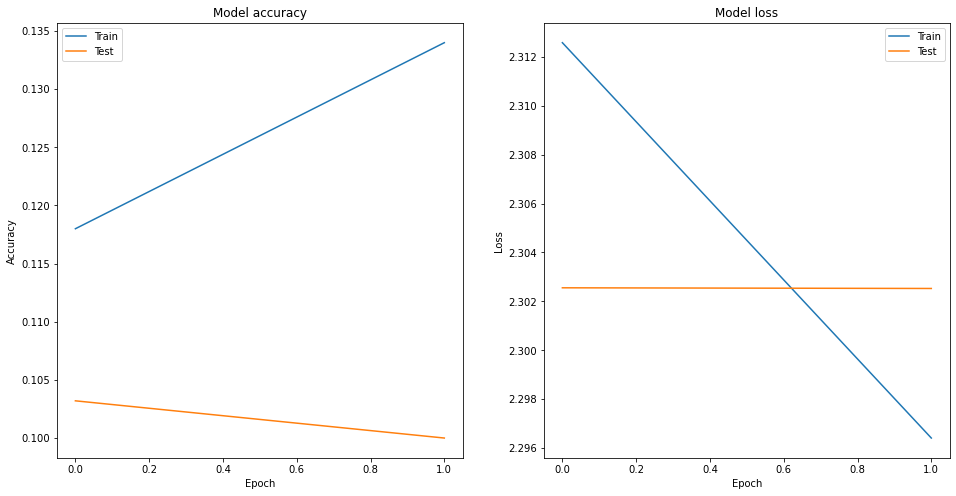

In [37]:
_, _ = model.plot_training()

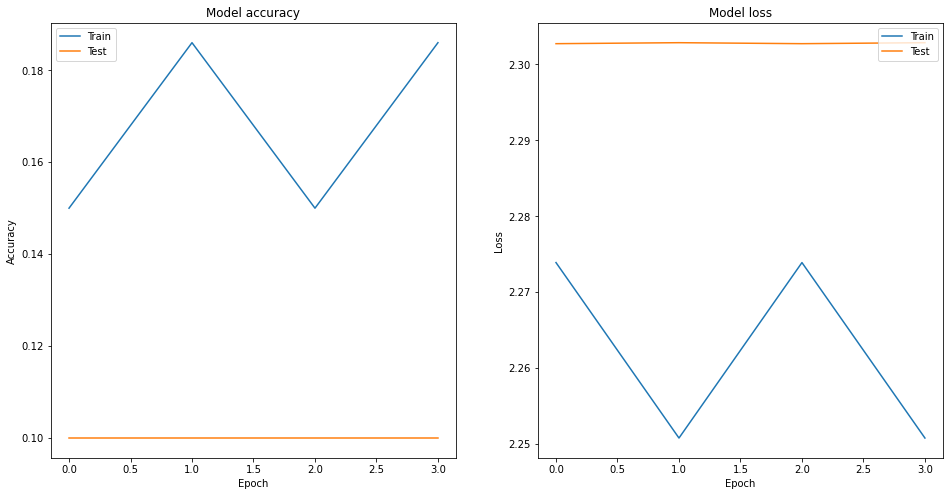

In [42]:
MODEL_NAME = '10epochs_nosig'
model.save_weights(f'models/{MODEL_NAME}')
model.save_training(f'img/{MODEL_NAME}.svg')

In [40]:
model.history.__dict__

{'validation_data': None,
 'model': <__main__.SimpleNet at 0x7fa387b2edf0>,
 '_chief_worker_only': None,
 'params': {'batch_size': 100,
  'epochs': 4,
  'steps': 5,
  'samples': 50000,
  'verbose': 0,
  'do_validation': True,
  'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']},
 'epoch': [2, 3, 2, 3],
 'history': {'loss': [2.273893928527832,
   2.250779914855957,
   2.273893928527832,
   2.250779914855957],
  'accuracy': [0.15, 0.186, 0.15, 0.186],
  'val_loss': [2.302732193470001,
   2.3028625202178956,
   2.302732193470001,
   2.3028625202178956],
  'val_accuracy': [0.1, 0.1, 0.1, 0.1]}}